## 1. Data Loading and Imports

In [48]:
# Basic libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# Text processing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

# Feature extraction
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec
from transformers import AutoTokenizer, AutoModel

# Model selection & evaluation
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Classification models
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

# Set random seed
np.random.seed(42)

In [49]:
# Load data
df_train = pd.read_csv(r'C:\Users\inesm\OneDrive\Documentos\GitHub\text_mining_2025\Dados\train.csv')
df_test = pd.read_csv(r'C:\Users\inesm\OneDrive\Documentos\GitHub\text_mining_2025\Dados\test.csv')
print(df_train.shape, df_test.shape)
df_train.head()

(9543, 2) (2388, 2)


,text,label
0,$BYND - JPMorgan reels in expectations on Beyo...,0
1,$CCL $RCL - Nomura points to bookings weakness...,0
2,"$CX - Cemex cut at Credit Suisse, J.P. Morgan ...",0
3,$ESS: BTIG Research cuts to Neutral https://t....,0
4,$FNKO - Funko slides after Piper Jaffray PT cu...,0


## 2. Data Exploration

### 2.1 Class Distribution

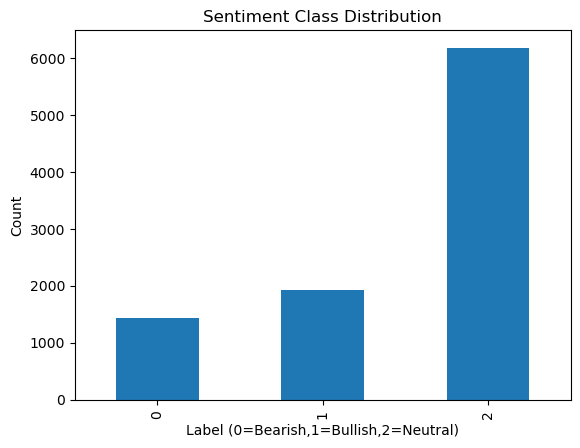

In [50]:
# Bar plot of label counts
df_train['label'].value_counts().sort_index().plot(kind='bar')
plt.title('Sentiment Class Distribution')
plt.xlabel('Label (0=Bearish,1=Bullish,2=Neutral)')
plt.ylabel('Count')
plt.show()

### 2.2 Common Words and Word Clouds

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\inesm\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


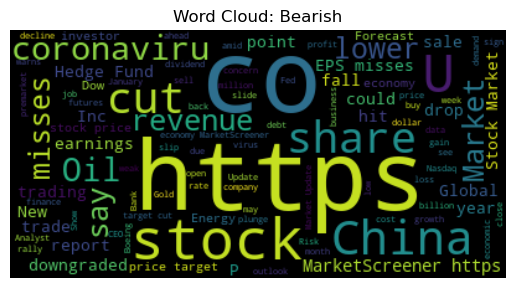

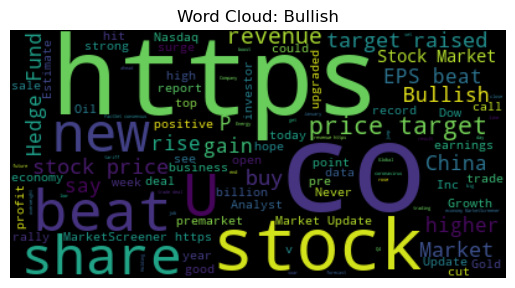

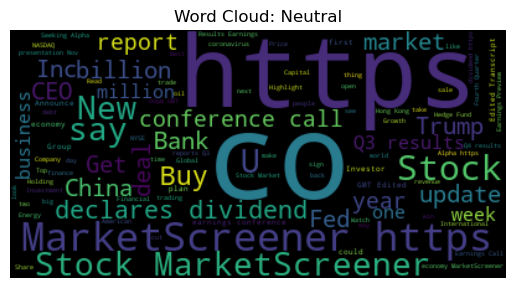

In [51]:
# Combine all tweets per class and generate word clouds
labels = {0:'Bearish', 1:'Bullish', 2:'Neutral'}
# Download NLTK stopwords once
nltk.download('stopwords')
stop = set(stopwords.words('english'))

for lbl in df_train['label'].unique():
    # Concatenate all texts for the current label
    text = ' '.join(df_train[df_train['label'] == lbl]['text'])
    wc = WordCloud(stopwords=stop, max_words=100).generate(text)
    plt.figure()
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud: {labels[lbl]}')
    plt.show()

## 3. Corpus Split

In [52]:
# Train/Validation split
X_train, X_val, y_train, y_val = train_test_split(
    df_train['text'], df_train['label'], test_size=0.2, stratify=df_train['label'], random_state=42)
print('Train:', X_train.shape, 'Validation:', X_val.shape)

Train: (7634,) Validation: (1909,)


## 4. Data Preprocessing

Implement at least four techniques: lowercasing, regex cleaning, stopword removal, lemmatization, stemming.

In [53]:
# Preparar recursos
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# NLTK downloads necessários para lemmatization
import nltk
nltk.download('wordnet')

stop = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Função simples sem NLTK tokenizers
def preprocess(text):
    # 1) Lowercase
    text = text.lower()
    # 2) Remover URLs e pontuação
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    # 3) Tokenização simples
    tokens = text.split()
    # 4) Remover stopwords e lemmatizar
    tokens = [lemmatizer.lemmatize(tok) for tok in tokens if tok not in stop]
    return ' '.join(tokens)

# Aplicar ao corpus
X_train_p = X_train.apply(preprocess)
X_val_p   = X_val.apply(preprocess)# Downloads NLTK necessários

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\inesm\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## 5. Features & Modelo de Baseline

### 5.1 Bag of Words + K-Nearest Neighbors

In [54]:
# BoW
cv = CountVectorizer(max_features=5000)
X_tr_bow = cv.fit_transform(X_train)
X_vl_bow = cv.transform(X_val)

# KNN
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_tr_bow, y_train)
y_pred_knn = knn.predict(X_vl_bow)

In [55]:
# TF-IDF
tfidf = TfidfVectorizer(max_features=5000)
X_tr_tfidf = tfidf.fit_transform(X_train)
X_vl_tfidf = tfidf.transform(X_val)

# Logistic Regression
lr = LogisticRegression(max_iter=500)
lr.fit(X_tr_tfidf, y_train)
y_pred_lr = lr.predict(X_vl_tfidf)

In [56]:
# Treinar Word2Vec no corpus de treino
w2v = Word2Vec([text.split() for text in X_train], vector_size=100, window=5, min_count=5)

def embed_mean_w2v(text):
    vecs = [w2v.wv[w] for w in text.split() if w in w2v.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(100)

# Gerar features
X_tr_w2v = np.vstack(X_train.map(embed_mean_w2v))
X_vl_w2v = np.vstack(X_val.map(embed_mean_w2v))

# Logistic Regression
lr_w2v = LogisticRegression(max_iter=500)
lr_w2v.fit(X_tr_w2v, y_train)
y_pred_w2v = lr_w2v.predict(X_vl_w2v)

In [57]:
# tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
# model_tr = AutoModel.from_pretrained('distilbert-base-uncased')

# # Função para embeddings
# def embed_transformer(texts):
#     inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
#     with torch.no_grad():
#         outputs = model_tr(**inputs)
#     return outputs.last_hidden_state.mean(dim=1).numpy()

# # Calcular embeddings (por batches se necessário)
# X_tr_tr = embed_transformer(list(X_train))
# X_vl_tr = embed_transformer(list(X_val))

# # Dataset e DataLoader simples
# class SentimentDataset(torch.utils.data.Dataset):
#     def __init__(self, X, y):
#         self.X = torch.tensor(X, dtype=torch.float32)
#         self.y = torch.tensor(y.values, dtype=torch.long)
#     def __len__(self): return len(self.y)
#     def __getitem__(self, i): return self.X[i], self.y[i]

# train_ds = SentimentDataset(X_tr_tr, y_train)
# val_ds   = SentimentDataset(X_vl_tr, y_val)
# train_loader = torch.utils.data.DataLoader(train_ds, batch_size=16, shuffle=True)
# val_loader   = torch.utils.data.DataLoader(val_ds, batch_size=16)

# # Definição do modelo denso
# class DenseNN(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.fc1 = nn.Linear(768, 128)
#         self.dropout = nn.Dropout(0.1)
#         self.fc2 = nn.Linear(128, 3)
#     def forward(self, x):
#         x = torch.relu(self.fc1(x))
#         x = self.dropout(x)
#         return self.fc2(x)

# device = torch.device('cpu')
# net = DenseNN().to(device)
# optimizer = torch.optim.Adam(net.parameters(), lr=1e-4)
# criterion = nn.CrossEntropyLoss()

# # Treino (1 época para exemplo)
# net.train()
# for X_batch, y_batch in train_loader:
#     X_batch, y_batch = X_batch.to(device), y_batch.to(device)
#     optimizer.zero_grad()
#     logits = net(X_batch)
#     loss = criterion(logits, y_batch)
#     loss.backward()
#     optimizer.step()

# # Avaliação rápida
# y_pred_tr = []
# net.eval()
# with torch.no_grad():
#     for X_batch, _ in val_loader:
#         logits = net(X_batch.to(device))
#         y_pred_tr.extend(logits.argmax(dim=1).cpu().numpy())

In [58]:
from sklearn.metrics import classification_report, confusion_matrix
print("KNN on BoW:", classification_report(y_val, y_pred_knn))
print("LR on TF-IDF:", classification_report(y_val, y_pred_lr))
print("LR on W2V:", classification_report(y_val, y_pred_w2v))
# print("DenseNN on DistilBERT:
# ", classification_report(y_val, y_pred_tr))

KNN on BoW:               precision    recall  f1-score   support

           0       0.69      0.11      0.19       288
           1       0.76      0.19      0.31       385
           2       0.69      0.98      0.81      1236

    accuracy                           0.69      1909
   macro avg       0.71      0.43      0.44      1909
weighted avg       0.70      0.69      0.62      1909

LR on TF-IDF:               precision    recall  f1-score   support

           0       0.79      0.42      0.55       288
           1       0.81      0.55      0.65       385
           2       0.79      0.96      0.87      1236

    accuracy                           0.79      1909
   macro avg       0.80      0.64      0.69      1909
weighted avg       0.80      0.79      0.78      1909

LR on W2V:               precision    recall  f1-score   support

           0       0.00      0.00      0.00       288
           1       0.57      0.11      0.19       385
           2       0.67      0.99     

c:\Users\inesm\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\inesm\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\inesm\anaconda3\envs\textmining\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(r